# **Time to Earthquake Prediction Kernel**

## This kernel describes a holistic procedure to solve the given problem. We will start by exploring the data, followed by feature extraction, and finally, use an appropriate model to make predictions after training and validation.

### Sequence of Steps:
1. Load the training data from the given dataset.
2. Visualise the training data - Input Acoustic Signal and Time_To_Failure
3. Extract Features using appropriate mathematical functions
4. Train and Validate using an appropriate model
5. Make Predictions
6. Save results


This kernel is inspired from Lavanya's kernel that can be found [here](https://www.kaggle.com/lavanyadml/lanl-earthquake-prediction)

## ** Step 1: Loading the Training Data and Dataframe setup**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

from tqdm import tqdm, tqdm_notebook
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv']


In [2]:
train_data = pd.read_csv('../input/train.csv',dtype={'acoustic_data': np.int16, 'time_to_failure':np.float64})

In [3]:
pd.options.display.precision = 10
train_data.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [4]:
print("Dimensions of the training data, Rows: {}, Columns:{}".format(train_data.shape[0],train_data.shape[1]))

Dimensions of the training data, Rows: 629145480, Columns:2


## **Step 2: Data Visualisation**

### Since the dataset is massive, we plot only 1 in every 100 points that is given to us, or in other words 1% of the given data

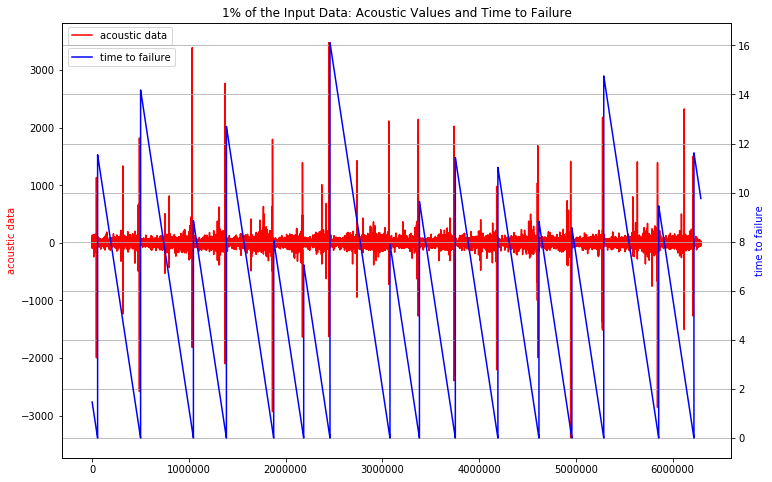

In [5]:
acoustic_values = train_data['acoustic_data'].values[::100]
time_to_failure_values = train_data['time_to_failure'].values[::100]

fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("1% of the Input Data: Acoustic Values and Time to Failure")
plt.plot(acoustic_values, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(time_to_failure_values, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

## **Important Note**

### The data is recorded in segments at a frequency of 4MHz, each segment lasting for 0.0375 seconds, thus constituting 150,000 data points.

### So, we will now plot the first 6,000,000 points in the dataset, or in other words, the first 40 segments.

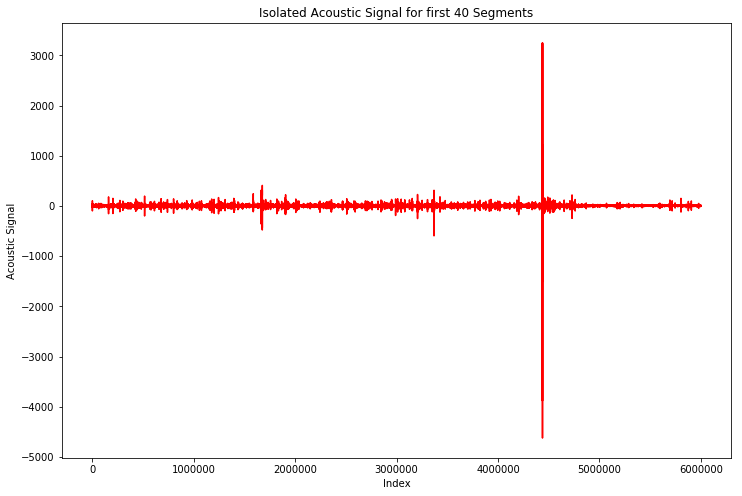

In [6]:
acoustic_values = train_data['acoustic_data'].values[0:6000000]
plt.figure(2,figsize=(12,8))
plt.title("Isolated Acoustic Signal for first 40 Segments")
plt.xlabel("Index")
plt.ylabel("Acoustic Signal")
plt.plot(acoustic_values, color='r')

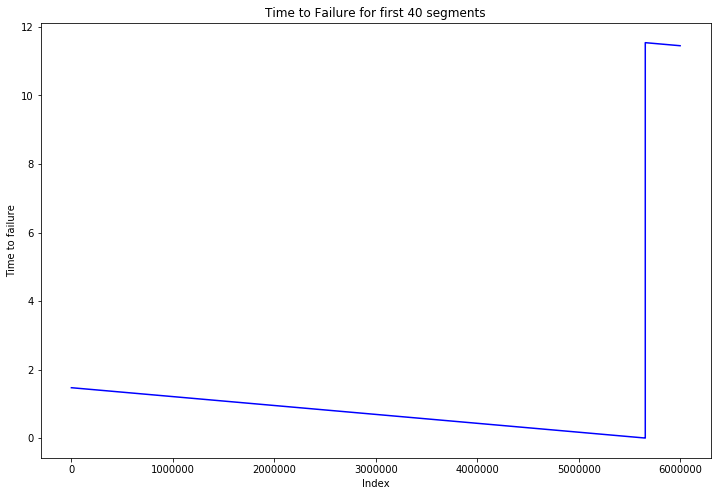

In [7]:
time_to_failure_values = train_data['time_to_failure'].values[0:6000000]
plt.figure(3,figsize=(12,8))
plt.title("Time to Failure for first 40 segments")
plt.xlabel("Index")
plt.ylabel("Time to failure")
plt.plot(time_to_failure_values,color='b')

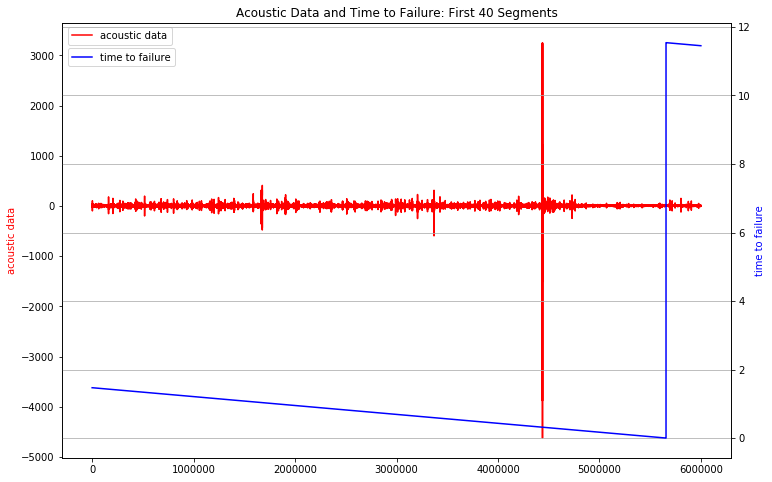

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("Acoustic Data and Time to Failure: First 40 Segments")
plt.plot(acoustic_values, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(time_to_failure_values, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

## **Summary**

### We see that the acoustic signal shows a massive spike, followed by a quieter than usual period in the build up to an Earthquake, when Time_to_Failure hits 0

## **Step 3: Feature Extraction**

### The entire data is first split into segments of 150,000 data points each, giving us 4194 segments to train on.

### In this step, the data to be trained on is created by extracting features. To capture the inherent frequency-magnitude characteristics of the wave, we use the **Fast Fourier Transform (FFT)** on each segment and take the real and imaginary components and calculate the mean, standard deviation, maximum and minimum for each.

### In addition, we take several other features such as the quartiles, Median Absolute Deviation (MAD), in addition to basic statistical features of standard deviation, mean, max and min. Some other functions such as kurtosis and skew are also used.

In [9]:
segment_size = 150000
num_segments = int(np.floor(train_data.shape[0]/segment_size))

X_train = pd.DataFrame(index=range(num_segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(num_segments), dtype=np.float64, columns=['time_to_failure'])

In [10]:
def create_features(segment, seg, X_tr):
    x = pd.Series(seg['acoustic_data'].values)
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
#     X_tr.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
#     X_tr.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
#     X_tr.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
#     X_tr.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
#     X_tr.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
#     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
#     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
#     X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
#     X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
#     X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
#     X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
#     X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
#     X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
#     X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
#     X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
#     X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
#     X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

## ** Step 4: Training and Validation ** 

### We start off by creating the training data, and targets.

### This is followed by scaling the training data, and the same is then done for the testing data.

In [11]:
for seg_id in tqdm_notebook(range(num_segments)):
    seg = train_data.iloc[seg_id*segment_size:seg_id*segment_size+segment_size]
    create_features(seg_id, seg, X_train)
    y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/

### Scaling the training data

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

,mean,std,max,min,mean_change_abs,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,abs_mean,abs_std,mad,kurt,skew,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.4241404998,-0.1702135829,-0.2181935087,0.1932181852,-1.3264196021,-0.2225668179,0.0,0.0520671203,-0.2855788026,0.7242225026,-0.1924222891,1.6018609646,0.3672218150,2.1692338541,0.5022240978,-0.0425128121,0.4658512660,-0.5633056033,0.4068071394,0.0119068855,-0.4001671925,0.7186115669,-0.4536695014,-0.4053309969,-0.1074714178,-0.0739189169,1.4241404998,-0.0983930971,-0.1633661486,0.0789750565,0.2287324620,-0.0217572374,-0.1590558892,0.2566047145,0.0,0.0191336119,-0.1699847390,-0.1355550505,-0.4913099051,-0.3137031809,...,0.0878534134,0.1380297323,-0.2528526854,-0.1882982427,-0.1256155274,-1.4183085587,-0.1859957825,1.4231479486,-0.0986037079,-0.1535393381,0.2414309745,0.3057299118,1.0537269015,1.2459100258,0.1556635814,-0.4871488121,-1.3921806738,-0.1531940607,-0.1646385417,-0.1874110911,-0.1121626376,0.2869953698,0.1023091551,0.1845985629,-0.4316049675,-0.2085015918,-0.2964620706,-1.8236216363,-0.1121626376,1.4210358888,0.2684701309,-0.0047418905,0.1782777240,0.2873321460,0.9654024466,1.5091534305,0.8852621217,-0.6313003435,-1.8324221759,-0.0047418905
1,0.8057160326,0.0047340170,0.0639360080,-0.0180372712,0.0027466478,0.0367965060,0.0,0.1538582924,-0.0769870413,-0.1958687382,-0.3104695224,0.6482088283,0.9785845607,0.8459579833,1.2703195866,-0.3848776835,-0.1400020327,0.1976337729,0.2825586537,0.5411822871,0.0269767300,-0.3164805145,-0.4016976388,0.1342197387,0.1634108090,-0.0739189169,0.8057160326,0.3256967742,0.0475309667,0.0789750565,0.0160612252,-0.0217572374,-0.0329262552,0.2566047145,0.0,0.1230231803,-0.0021665047,0.0562333733,0.4316957049,0.5538912151,...,0.0534179730,0.1417533707,0.0311378209,-0.0433284606,-0.0151006770,-1.1074566077,0.0861142762,0.8051420808,-0.0461044457,0.1159506052,0.0059512340,0.1981702611,0.6978667133,0.6212460962,0.0229968347,-0.1370075770,-1.0977648067,0.1128522787,0.0871079553,0.0179809857,-0.0229227545,-0.1434462372,0.0506437688,-0.1510817038,-0.0483818668,0.1481061291,-0.0036885747,-0.8951046689,-0.0229227545,0.8020524394,-0.1412643220,0.0073413893,-0.0253869482,0.6223914659,0.8427470522,0.5224275422,0.2943568175,-0.9120539709,-0.8900224807,0.0073413893
2,1.5111552594,0.0492521967,-0.0862887996,0.1630388343,-0.2187810605,-0.1013060431,0.0,0.0042407932,0.2778851194,0.3739666349,0.6812217650,0.6760553260,2.0677337743,0.5327914111,2.1281548748,0.0247374305,-0.0819948020,-0.4517011614,-0.4474011993,-0.0362090601,0.1799048010,0.6220029727,0.7416833378,0.8219214142,0.2537048847,-0.0739189169,1.5111552594,0.7497866455,0.3990261588,-0.3472250169,-0.2675004238,0.4400335196,0.1562681958,0.2566047145,0.0,0.3988842627,0.0174000955,0.2870142011,-0.4928308995,0.1915337154,...,1.1434554699,0.8562195153,0.6664321534,0.0711845444,0.1216615982,0.5266227655,-0.1782184062,1.5099459356,-0

In [13]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


In [14]:
submission_files = pd.read_csv('../input/sample_submission.csv',index_col='seg_id')
submission_files

X_test = pd.DataFrame(columns=X_train.columns,index=submission_files.index,dtype=np.float64)

for seg_id in tqdm_notebook(X_test.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    create_features(seg_id, seg, X_test)

X_test.head()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:2831: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.mean(atmp[sl], axis=axis)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


,mean,std,max,min,mean_change_abs,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,abs_mean,abs_std,mad,kurt,skew,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.4917800000,4.8936896870,115.0,-75.0,0.0000266668,115.0,0.0,5.3504510345,4.7938756205,5.2268463104,6.0190170798,4.46644,4.49598,4.3842,4.2675,-75.0,-37.0,-36.0,-37.0,115.0,43.0,45.0,43.0,1.5333333333,40.0,0.0,673767.0,11.0,18.0,-2.0,-8.0,11.0,19.0,1.0,0.0,5.2246066667,4.1021608976,3.2485210541,28.8375680992,0.3279076353,...,2.3436783659,2.5149853906,8.3622226517,16.0264270390,-0.0000118589,75008.2618433949,50.4899980094,4.4917178004,0.4199268649,10.42,-0.22,3.48,3.83,5.15,5.48,0.0000004670,75004.5413771825,10.42,4.2376624304,2.4395703055,24.7172467376,2.4907436247,2.6511289076,2.7501904566,8.5082560740,13.1559521920,-0.0000340741,74583.7498617739,24.7172467376,4.4914683190,0.2318909797,5.495,3.774,3.889,4.099,4.867,5.000,0.0000017785,74583.5961588826,5.495
seg_0012b5,4.1711533333,5.9228394432,152.0,-140.0,-0.0000133334,152.0,0.0,6.2495153531,4.1475623120,3.5232526280,3.6051473560,4.01786,4.24444,4.0635,4.1285,-140.0,-36.0,-12.0,-19.0,152.0,49.0,22.0,40.0,1.0857142857,12.0,0.0,625673.0,11.0,20.0,-2.0,-12.0,12.0,24.0,1.0,0.0,5.1983400000,5.0453685973,3.4292084979,56.2189545505,0.2957078592,...,2.3110406943,2.4756592837,9.9547257951,24.1731527346,-0.0000243321,74815.3923271911,58.3733118416,4.1714696366,0.4704311149,11.90,-3.45,3.13,3.50,4.83,5.24,-0.0000010674,74810.3078308484,11.90,4.5959508500,3.7533878612,29.6803109292,2.5409319816,2.6379983008,2.7063990089,10.9333461052,24.3313469715,-0.0000065522,74347.2808308942,29.6803109292,4.1736328213,0.2309136613,5.009,3.342,3.644,3.790,4.541,4.739,-0.0000001946,74346.8332847969,5.009
seg_00184e,4.6102600000,6.9469900775,248.0,-193.0,-0.0000200001,248.0,0.0,9.7934730004,5.2259134860,3.9501186443,3.0630570337,4.55518,4.55380,4.2452,4.7272,-193.0,-78.0,-26.0,-8.0,248.0,92.0,49.0,19.0,1.2849740933,55.0,0.0,691539.0,11.0,20.0,-2.0,-11.0,12.0,25.0,1.0,0.0,5.5971933333,6.1795249035,3.4619840107,162.1182836284,0.4286882883,...,2.3125481158,2.4756388830,8.8703569445,26.8856069038,-0.0000005063,74886.3670232897,106.2967349385,4.6104857873,0.5209808948,19.11,-4.96,3.48,3.90,5.27,5.66,-0.0000020680,74886.4111024591,19.11,4.6849671030,5.1542678755,53.0692922581,2.5024574508,2.6141793997,2.6764667893,10.0849993164,31.0753934179,0.0000006882,74348.9296306302,53.0692922581,4.6124554131,0.2472192612,6.234,3.544,4.013,4.215,4.966,5.082,0.0000000805,74349.4644588517,6.234
seg_003339,4.5314733333,4.1141466030,85.0,-93.0,0.0000466670,93.0,0.0,3.6640876955,3.4808398579,4.0012754792,2.7711848922,4.49052,4.48922,4.3834,4.4668,-30.0,-54.0,-23.0,-7.0,51.0,72.0,34.0,15.0,0.9139784946,-8.0,0.0,679721.0,10.0,14.0,-1.0,-5.0,10.0,16.0,1.0,0.0,4.9614866667,3.5838632345,2.6785027580,41.2418274621

In [15]:
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index = submission_files.index)
X_test_scaled.head()

,mean,std,max,min,mean_change_abs,abs_max,abs_min,std_first_50000,std_last_50000,std_first_10000,std_last_10000,avg_first_50000,avg_last_50000,avg_first_10000,avg_last_10000,min_first_50000,min_last_50000,min_first_10000,min_last_10000,max_first_50000,max_last_50000,max_first_10000,max_last_10000,max_to_min,max_to_min_diff,count_big,sum,q95,q99,q05,q01,abs_q95,abs_q99,abs_q05,abs_q01,abs_mean,abs_std,mad,kurt,skew,...,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,av_change_rate_roll_std_100,abs_max_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,1.3602626454,-0.2047898189,-0.1833281333,0.2715217513,0.4571183104,-0.1882420596,0.0,-0.0954686137,-0.2974019935,-0.0387985413,0.1156572820,1.1606024907,1.2804822635,0.7427938441,0.3796486414,0.1049761728,0.5690778538,0.0792378389,0.0939092121,0.0080619765,-0.5990353285,-0.0848631940,-0.1455790687,1.8769777011,0.4045960082,-0.0698929412,1.3602626454,0.0004718856,-0.1651494699,0.2865031382,0.2741005359,-0.2221033417,-0.1947867517,0.90746269,0.0,-0.0520933669,-0.2027490748,-0.1731977370,-0.5840683362,0.4760881635,...,0.5789643880,0.4730701737,-0.2874231283,-0.2067054056,-0.2068598839,0.4076393228,-0.1956295759,1.3599741089,-0.1386950765,-0.1242722184,0.1827649827,0.3099747879,1.1855848985,1.0016388839,0.0597956217,0.1044479505,0.4103613021,-0.1217539839,-0.2200169450,-0.2338863205,-0.1937832977,-0.5151514583,0.5126455238,0.5290712089,-0.4470375141,-0.2455370754,-0.7862834112,0.5630521314,-0.1937832977,1.3587492740,-0.1232896568,0.0477399377,0.2293472808,0.6394519009,1.2861961401,1.1474636480,0.6100190393,0.7095544442,0.5631806927,0.0477399377
seg_0012b5,0.0893369943,-0.0870781104,-0.0494953152,0.0483997811,-0.2684458270,-0.0682653965,0.0,-0.0315439555,-0.4539023786,-0.1874730032,-0.4103598552,-0.4937288472,0.3574933270,-0.2994208915,-0.0699837268,-0.1359573799,0.5796230304,0.3184211848,0.4189747970,0.1546115314,-0.5384386129,-0.3282651274,-0.1967648487,-0.2423779990,0.0059253640,-0.0698929412,0.0893369943,0.0004718856,-0.0291783461,0.2865031382,0.0056345626,0.0065170759,-0.0462076482,0.90746269,0.0,-0.0684898950,-0.0927576147,-0.0668431649,-0.1814763892,0.4028328178,...,0.1038413358,0.0313845343,-0.0008854322,-0.0412615478,-0.4204148088,-1.0647402501,-0.1406125281,0.0905640049,-0.0829715661,-0.0708223701,0.0627496525,0.1155299559,0.1355581264,-0.0203253656,-0.0819528189,-0.2270610008,-1.0766270850,-0.0708044566,-0.0655978219,-0.0810812790,-0.1356876548,0.2738648930,0.3239448224,0.0775797584,-0.0326090896,-0.0395529248,-0.1464972829,-1.0514676295,-0.1356876548,0.0992691632,-0.1289025283,-0.0786597134,0.0903801937,0.1557120436,0.1764464457,-0.0333074674,0.0387099169,-0.0548179928,-1.0545354258,-0.0786597134
seg_00184e,1.8299031551,0.0300618104,0.2977465911,-0.1335304409,-0.3893731832,0.2430254048,0.0,0.2204361052,-0.1927869540,-0.1502199446,-0.5284891796,1.4878693393,1.4926442270,0.2910699643,1.8666702220,-0.3324108920,0.1367256101,0.1788975664,0.6176259878,0.5348482144,-0.1041621515,-0.0425324230,-0.5550653087,0.7010635528,0.6181695676,-0.0698929412,1.8299031551,0.0004718856,-0.0291783461,0.2865031382,0.0727510559,0.0065170759,-0.0164918275,0.90746269,0.0,0.1804876399,0.0395011741,-0.0475511457,1.3755746809,0.7

In [16]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, loss='huber')
num_folds = 3
cross_validate_results = cross_validate(model, X_train_scaled, y_train.values.flatten(), n_jobs=-1, return_estimator= True, return_train_score=True, cv=num_folds, verbose=50, scoring="neg_mean_absolute_error" )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.9s finished


In [17]:
cross_validate_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_score', 'train_score'])

In [18]:
for i in range(num_folds):
    print("Fold: {} Training MAE: {}".format(i,-cross_validate_results['train_score'][i]))
    print("Fold: {} Validation MAE: {}".format(i,-cross_validate_results['test_score'][i]))

Fold: 0 Training MAE: 1.5094290701894097
Fold: 0 Validation MAE: 2.1602970604503504
Fold: 1 Training MAE: 1.3949976986576518
Fold: 1 Validation MAE: 2.3913555239896223
Fold: 2 Training MAE: 1.5350012364927095
Fold: 2 Validation MAE: 2.2465501543398205


## ** Step 5: Make predictions and submit! **

### The model is chosen based on the cross validation results. It can be appropriately chosen as per one's own intuition and reasoning.

In [19]:
new_model = cross_validate_results['estimator'][0]
y_predictions = new_model.predict(X_train_scaled)
mean_absolute_error(y_predictions, y_train.values.flatten())

1.726385066943057

In [20]:
y_test_predictions = new_model.predict(X_test_scaled)
submission_files['time_to_failure'] = y_test_predictions
submission_files.to_csv('latest_submission.csv')
y_test_predictions

array([2.52130695, 5.80756079, 5.74612313, ..., 4.69593743, 1.27800771,
       8.61952784])

In [21]:
## Non validation seems to overfit. 1.49 is too less MAE.

model2 = GradientBoostingRegressor(n_estimators=300, loss='huber').fit(X_train_scaled,y_train.values.flatten())
y_predictions = model2.predict(X_train_scaled)
print(mean_absolute_error(y_predictions,y_train.values.flatten()))

y_test_new_preds = model2.predict(X_test_scaled)

1.4931259235848409


In [22]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

submission_files['time_to_failure'] = y_test_predictions

In [23]:
create_download_link(submission_files)